# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

keywords are unexpanded, not using


In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.114848,False,1.098307
1,-1.465593,True,2.574139
2,1.601921,False,3.339785
3,-1.942415,True,1.679678
4,-2.175915,True,1.988145
...,...,...,...
995,-1.380999,False,-3.378650
996,1.397422,False,3.309344
997,-1.662942,True,1.093377
998,-0.791503,False,-0.716235


<AxesSubplot:xlabel='v0'>

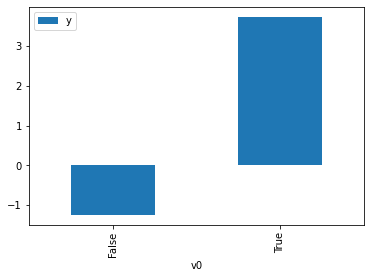

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

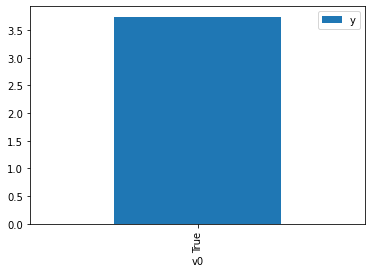

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.572402,False,0.159776,0.579420,1.725864
1,-0.731808,False,-0.520489,0.601547,1.662380
2,-0.569560,False,0.446424,0.579022,1.727050
3,-2.087775,False,-3.174004,0.766822,1.304084
4,0.530029,False,0.647976,0.422486,2.366940
...,...,...,...,...,...
995,1.108238,False,2.491340,0.344217,2.905142
996,-1.266161,False,-3.070048,0.672325,1.487377
997,-1.332551,False,-0.660859,0.680666,1.469148
998,-2.927385,False,-3.481850,0.841911,1.187773


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.737451,True,4.110883,0.397676,2.514607
1,-0.656442,True,1.697156,0.408869,2.445773
2,-0.063303,True,5.723438,0.492978,2.028488
3,-0.274949,True,4.683323,0.462668,2.161379
4,-1.554016,True,2.788685,0.292351,3.420543
...,...,...,...,...,...
995,-0.480167,True,3.484657,0.433537,2.306609
996,-0.622534,True,3.087660,0.413582,2.417899
997,-1.941976,True,-1.011835,0.248479,4.024486
998,-2.392156,True,0.590442,0.203394,4.916562


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.913
Model:                            OLS   Adj. R-squared (uncentered):              0.913
Method:                 Least Squares   F-statistic:                              5243.
Date:                Thu, 28 Jul 2022   Prob (F-statistic):                        0.00
Time:                        10:36:49   Log-Likelihood:                         -1411.2
No. Observations:                1000   AIC:                                      2826.
Df Residuals:                     998   BIC:                                      2836.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.4662      0.024     60.748      0.000       1.419       1.514
x2             4.9737      0.052     95.156      0.000       4.871       5.076
==============================================================================
Omnibus:                        5.402   Durbin-Watson:                   2.032
Prob(Omnibus):                  0.067   Jarque-Bera (JB):                5.396
Skew:                          -0.180   Prob(JB):                       0.0673
Kurtosis:                       2.998   Cond. No.                         2.28
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""